In [1]:
import os
import numpy
import csv
from scipy import integrate, linalg
from matplotlib import pyplot
%matplotlib inline

In [2]:
with open("resources/MainFoil_N=100.csv") as filein:
    reader = csv.reader(filein, quoting=csv.QUOTE_NONNUMERIC, skipinitialspace = True)
    x1, y1 = zip(*reader)
    x1 = numpy.asarray(x1)
    y1 = numpy.asarray(y1)

In [3]:
with open("resources/FlapFoil_N=100.csv") as filein:
    reader = csv.reader(filein, quoting=csv.QUOTE_NONNUMERIC, skipinitialspace = True)
    x2, y2 = zip(*reader)
    x2 = numpy.asarray(x2)
    y2 = numpy.asarray(y2)

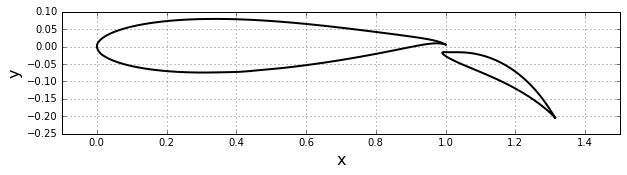

In [4]:
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x1, y1, x2, y2, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-.1, 1.5);
pyplot.ylim(-.25, .1);

In [5]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya # panel starting-point
        self.xb, self.yb = xb, yb # panel ending-point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        
        self.sigma = 0.0 # source strength
        self.vt = 0.0    # tangential velocity
        self.cp = 0.0    # pressure coefficient

In [6]:
def define_panels(x, y, N=40):
    """
    Discretizes the geometry into panels eveningly over the surface of the geometery 
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 40.
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects.
        The list of panels.
    """

    # create panels
    panels = numpy.empty(N, dtype=object)
    
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])
    
    return panels

In [7]:
panels1 = define_panels(x1,y1,N=(x1.size-1))
panels2 = define_panels(x2,y2,N=(x2.size-1))
panels = numpy.concatenate((panels1, panels2))

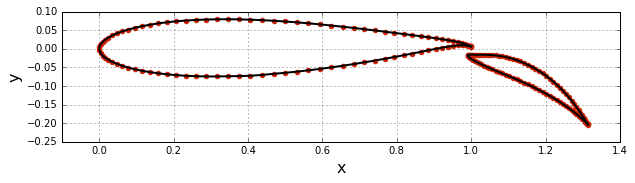

In [8]:
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x1, y1,x2,y2, color='k', linestyle='-', linewidth=2)
pyplot.scatter([panel.xa for panel in panels1],[panel.ya for panel in panels1], color='#CD2305')
pyplot.scatter([panel.xa for panel in panels2],[panel.ya for panel in panels2],color='#CD2305'),
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-0.25, 0.1);

In [9]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians

In [10]:
# set freestream
# define freestream conditions
freestream = Freestream(u_inf=1.0, alpha=0.0)

In [11]:
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return  ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [12]:
def source_contribution_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    return A

In [13]:
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

In [14]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

In [15]:
panels.size

200

In [16]:
B_vortex.shape[0]

200

In [17]:
def kutta_condition(A_source, B_vortex):   # NOT DONE
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 2D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    N = A_source.shape[0]
    k = numpy.empty([2,int(N+2)], dtype=float)
    k_temp = numpy.empty([int(N+2),int(N+2)])
    k_temp[:N,:N] = B_vortex
    k_temp[:N,-2] = -numpy.sum(A_source[:,:int(N/2)], axis = 1)
    k_temp[:N,-1] = -numpy.sum(A_source[:,int(N/2):], axis = 1)
    
    
    k[0,:] = k_temp[0,:] + k_temp[int(N/2)-1,:]
    k[1,:] = k_temp[int(N/2),:] + k_temp[-1,:]

    
    return k

In [18]:
def matrix(panels,A_source,B_vortex):
    N = A_source.shape[0]
    A = numpy.empty((A_source.shape[0]+2,A_source.shape[1]+2),dtype=float)
    A[:-2,:-2] = A_source
    #airfoil vortex contribution
    A[:-2,-2] = numpy.sum(B_vortex[:,:int(N/2)], axis = 1)
    #flap vortex contribution
    A[:-2,-1] = numpy.sum(B_vortex[:,int(N/2):], axis = 1)
    #airfoil/foil kutta condition
    A[-2:,:] = kutta_condition(A_source,B_vortex)
    
    return A

In [19]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    N = numpy.shape(panels)[0]
    b = numpy.empty(N+2,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition for airfoil
    b[-2] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[int(N/2)-1].beta) )
    # freesteam contribution on the Kutta condition for flap
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[int(N/2)].beta)
                               +numpy.sin(freestream.alpha-panels[int(N)-1].beta) )
    return b

In [20]:
A = matrix(panels,A_source,B_vortex)
b = build_freestream_rhs(panels,freestream)

In [21]:
strengths = numpy.linalg.solve(A,b)

for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
gamma = strengths[-2:]

In [22]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    N = A_source.shape[0]
    A = numpy.empty((N, N+2), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-2] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -2] = -numpy.sum(A_source[:,:int(N/2)], axis=1)
    A[:, -1] = -numpy.sum(A_source[:,int(N/2):], axis=1)
    # freestream contribution
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [23]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [24]:
compute_tangential_velocity(panels,freestream,gamma,A_source,B_vortex)
compute_pressure_coefficient(panels,freestream)

(-12, 2.0)

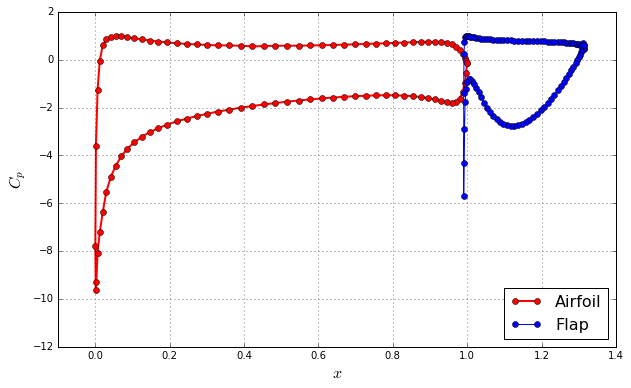

In [25]:
# plot surface pressure coefficient
N = panels.size
air,flap = panels[:int(N/2)] , panels[int(N/2):]
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in  air],
            [panel.cp for panel in  air],
            label='Airfoil',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in  flap],
            [panel.cp for panel in  flap],
            label= 'Flap',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-12, 2.0)


Solutions

In [26]:
sol1 = air[2].cp
sol2 = flap[9].cp
print(sol1,sol2)

-0.958725601669 -0.288367217005


In [28]:
lift_tot1 = 0
drag_tot1 = 0
for panel in panels:
    lift_tot1 -= panel.cp*panel.length*numpy.sin(panel.beta)
    drag_tot1 += panel.cp*panel.length*numpy.cos(panel.beta)
print(lift_tot1,drag_tot1)

3.70742227964 0.0105518831348


ReRun at 200 panels per element 

In [29]:
with open("resources/MainFoil_N=200.csv") as filein:
    reader = csv.reader(filein, quoting=csv.QUOTE_NONNUMERIC, skipinitialspace = True)
    x1, y1 = zip(*reader)
    x1 = numpy.asarray(x1)
    y1 = numpy.asarray(y1)

In [30]:
with open("resources/FlapFoil_N=200.csv") as filein:
    reader = csv.reader(filein, quoting=csv.QUOTE_NONNUMERIC, skipinitialspace = True)
    x2, y2 = zip(*reader)
    x2 = numpy.asarray(x2)
    y2 = numpy.asarray(y2)

In [31]:
panels1 = define_panels(x1,y1,N=(x1.size-1))
panels2 = define_panels(x2,y2,N=(x2.size-1))
panels = numpy.concatenate((panels1, panels2))
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)
A = matrix(panels,A_source,B_vortex)
b = build_freestream_rhs(panels,freestream)
strengths = numpy.linalg.solve(A,b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
gamma = strengths[-2:]
compute_tangential_velocity(panels,freestream,gamma,A_source,B_vortex)
compute_pressure_coefficient(panels,freestream)
lift_tot2 = 0
drag_tot2 = 0
for panel in panels:
    lift_tot2 -= panel.cp*panel.length*numpy.sin(panel.beta)
    drag_tot2 += panel.cp*panel.length*numpy.cos(panel.beta)
print(lift_tot2,drag_tot2)

3.72765753063 0.00543857772352


Improvment Check 

In [49]:
lift_act = 3.7476
diff1 = abs(lift_tot1 - lift_act)
diff2 = abs(lift_tot2 - lift_act)
percent =  (diff1-diff2)/diff1*100
print('improvment is',percent,'%')

improvment is 50.3643581791 %
